<a href="https://colab.research.google.com/github/quanndm/kltn/blob/dev/notebooks/tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Init - import library - download data

In [1]:
!rm -rf kltn
!rm -rf sample_data
!git clone -b dev https://github.com/quanndm/kltn.git

Cloning into 'kltn'...
remote: Enumerating objects: 1438, done.
remote: Counting objects: 100% (226/226), done.
remote: Compressing objects: 100% (166/166), done.
remote: Total 1438 (delta 150), reused 119 (delta 60), pack-reused 1212 (from 2)
Receiving objects: 100% (1438/1438), 14.64 MiB | 21.03 MiB/s, done.
Resolving deltas: 100% (938/938), done.


In [2]:
from kltn.init.install_dependencies import install_packages, load_config
install_packages("./kltn")
config = load_config("./kltn/parameters.yaml")

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive

from kltn import *
from kltn.datasets.get_datasets import get_datasets_lits
from kltn.utils.logger import init_logger
from kltn.utils.train_val_epochs import  trainer_stage2
from kltn.utils.metrics import  DiceMetric, TverskyLossWSigmoid, DiceLossWSigmoid
from kltn.models.model_factory import ModelFactory
from kltn.utils.visualize_results import visualize_results

In [4]:
drive.flush_and_unmount()
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
LOGGER = init_logger(config["log_path"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
from kltn.datasets.prepare_data import prepare_dataset_LiTS
prepare_dataset_LiTS(dir_name=config["source_folder_lits"])

0.00% complete (down: 0.0 kB/s up: 0.0 kB/s peers: 1) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (udp://tracker.opentrackr.org:1337/announce)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
1.07% complete (down: 16333.2 kB/s up: 465.4 kB/s peers: 9) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://ipv6.academictorrents.com/announce.ph

## Model

In [6]:
weight_path = "/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT_liver.pth"
model_stage_1 = ModelFactory.get_model("unet3d_resnextcot",in_channels=1, n_classes=1, n_channels=16).to(device)
model_stage_1.load_state_dict(torch.load(weight_path, map_location=device))

<All keys matched successfully>

In [7]:
model = ModelFactory.get_model("unet3d_resnextcot",in_channels=1, n_classes=1, n_channels=16).to(device)
model.load_state_dict({
    k: v for k, v in model_stage_1.state_dict().items() if "out" not in k
}, strict=False)

_IncompatibleKeys(missing_keys=['out.conv.weight', 'out.conv.bias'], unexpected_keys=[])

## Load data

In [8]:
full_train_dataset, val_dataset = get_datasets_lits(source_folder=config["source_folder_lits"], seed=123, fold_number=2, mode="tumor",model_stage_1=model_stage_1)
print(len(full_train_dataset), len(val_dataset))

105 26


In [9]:
train_loader = torch.utils.data.DataLoader(full_train_dataset, batch_size=1, shuffle=True,
                                           num_workers=0, pin_memory=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False,
                                         pin_memory=True, num_workers=0)

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch

def visualize_from_loader(image_tensor, label_tensor):
    """
    Visualize 3D volume (from DataLoader) using Max Intensity Projection (MIP)

    Args:
        image_tensor: Tensor, shape [1, 1, D, H, W]
        label_tensor: Tensor, shape [1, 1, D, H, W]

    Notes:
        - Converts to numpy
        - Projects to 2D using max projection along depth
    """

    # Convert to numpy, squeeze to shape [D, H, W]
    image = image_tensor.detach().cpu().numpy().squeeze()
    label = label_tensor.detach().cpu().numpy().squeeze()

    # Max projection along depth
    image_2d = np.max(image, axis=0)
    label_2d = np.max(label, axis=0)

    # Color map for tumor mask
    cmap = mcolors.ListedColormap(["black", "red"])

    # Plotting
    num_cols = 2
    plt.figure(figsize=(5 * num_cols, 5))

    plt.subplot(1, num_cols, 1)
    plt.title("Input Image (MIP)")
    plt.imshow(image_2d, cmap='gray')
    plt.axis("off")

    plt.subplot(1, num_cols, 2)
    plt.title("Ground Truth (Tumor MIP)")
    plt.imshow(image_2d, cmap='gray')
    plt.imshow(label_2d, cmap=cmap, alpha=0.5)
    plt.axis("off")


    plt.tight_layout()
    plt.show()


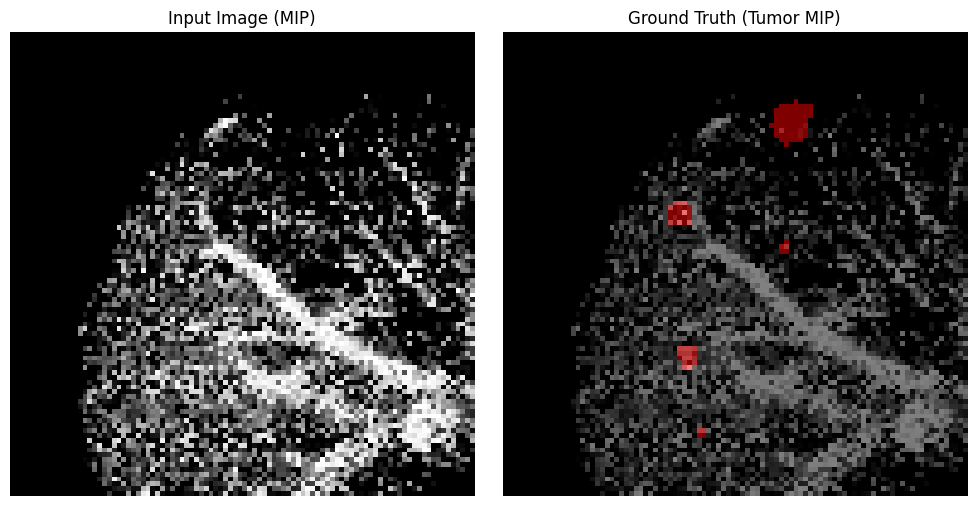

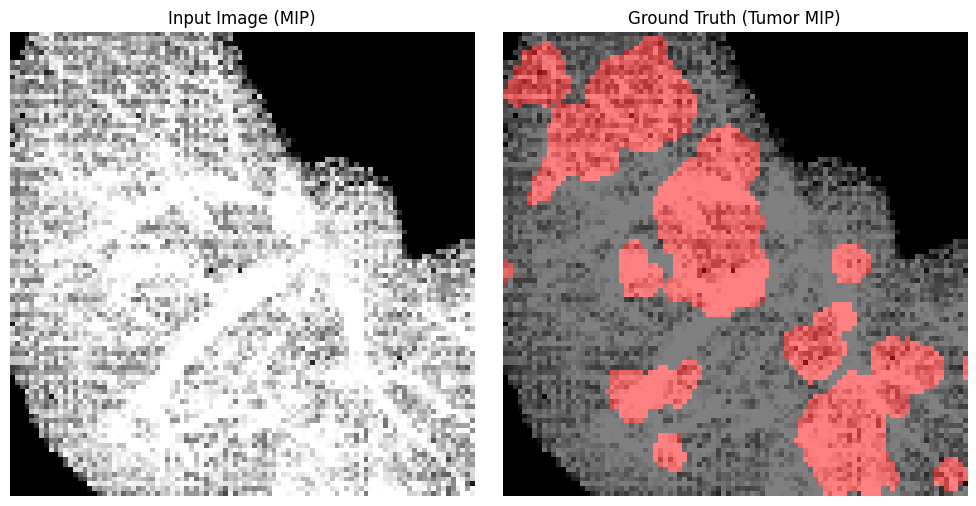

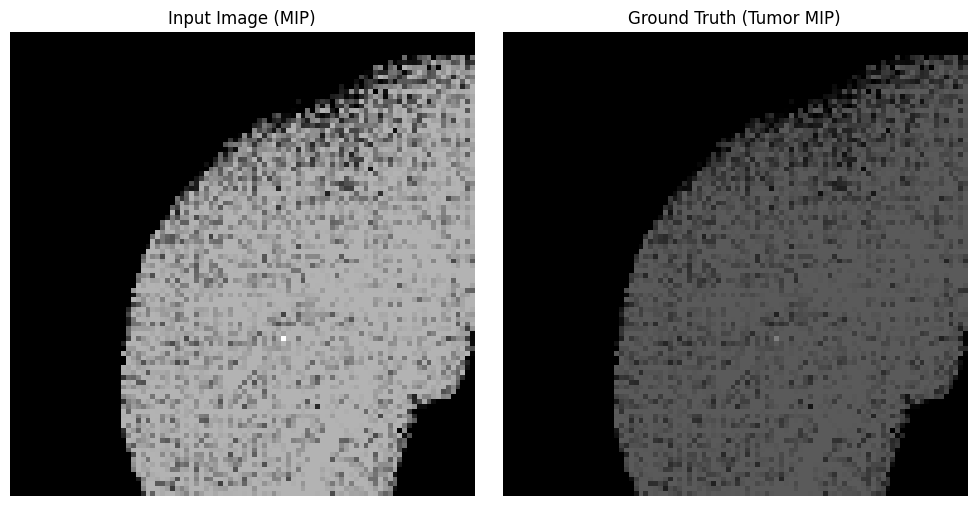

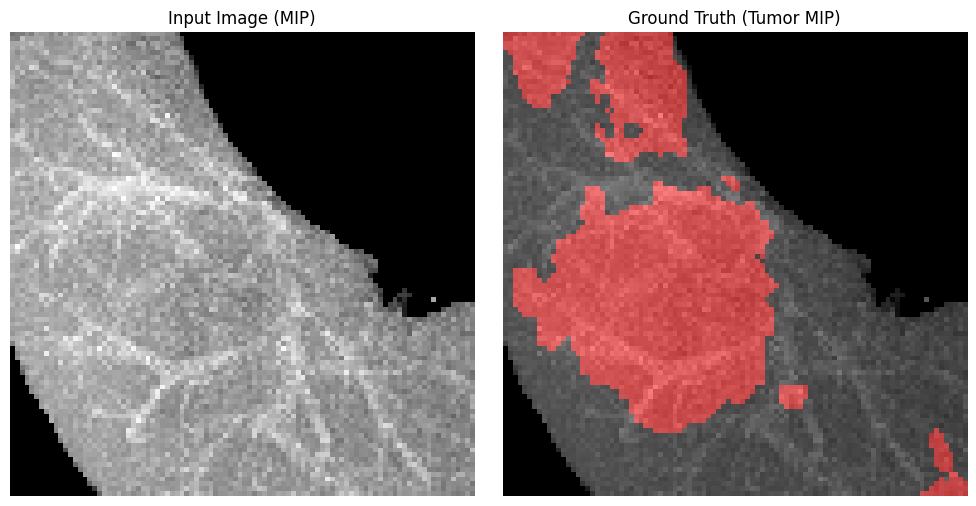

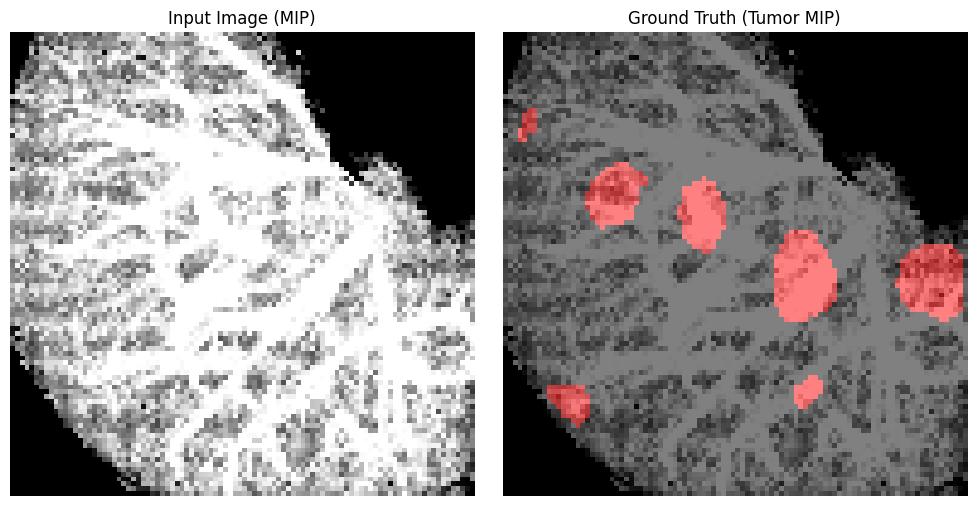

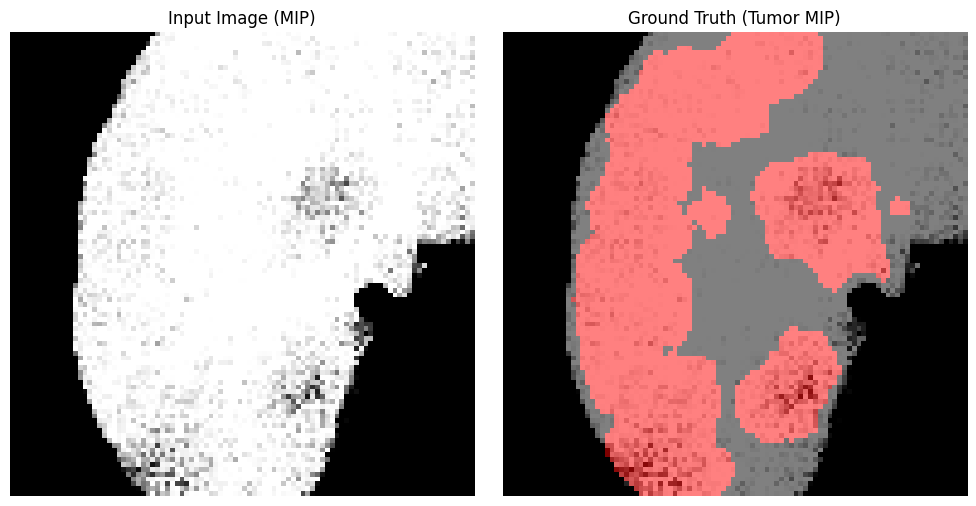

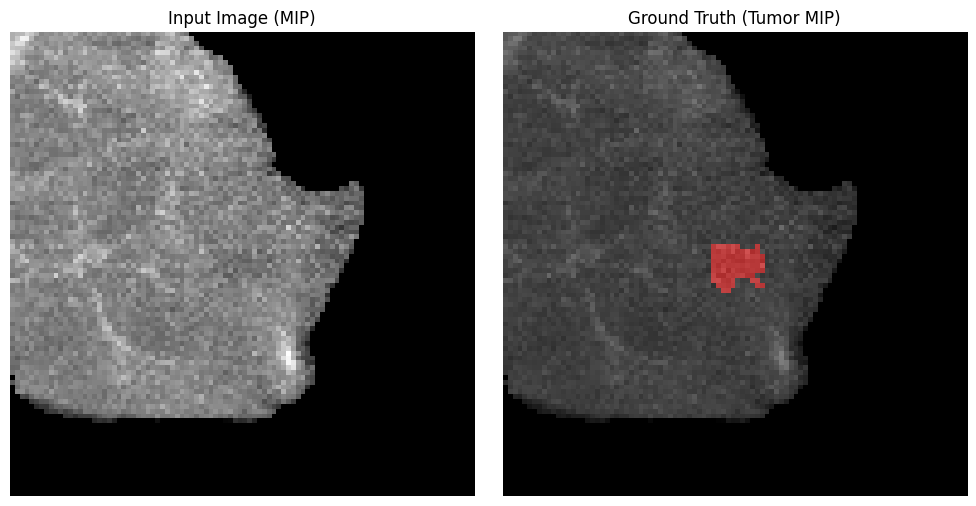

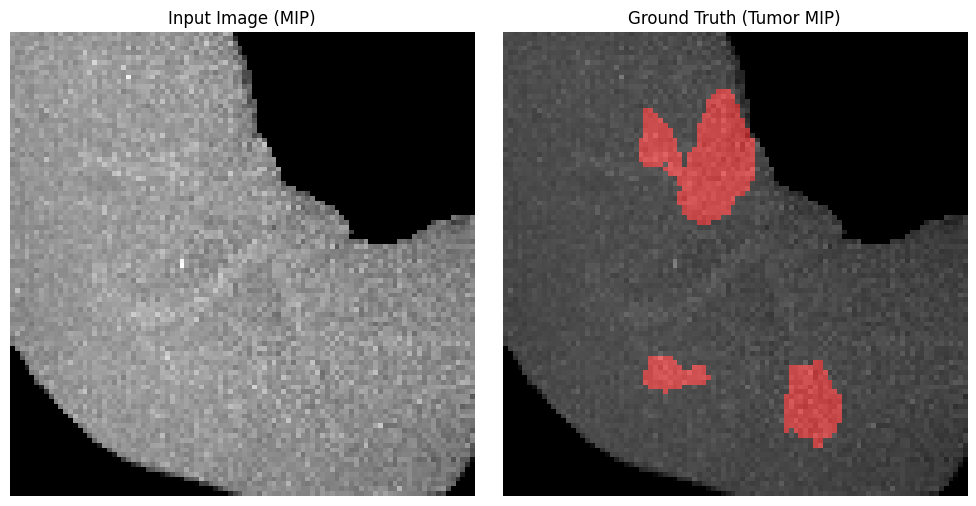

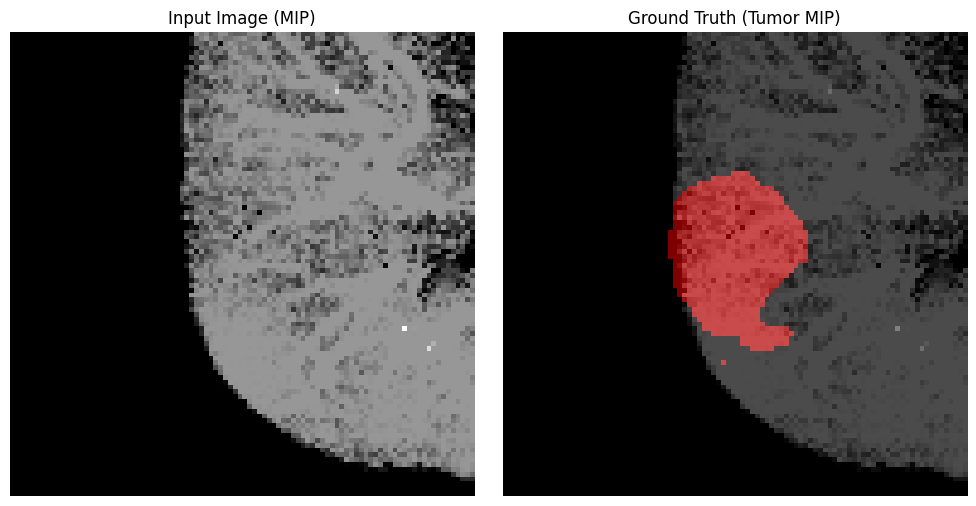

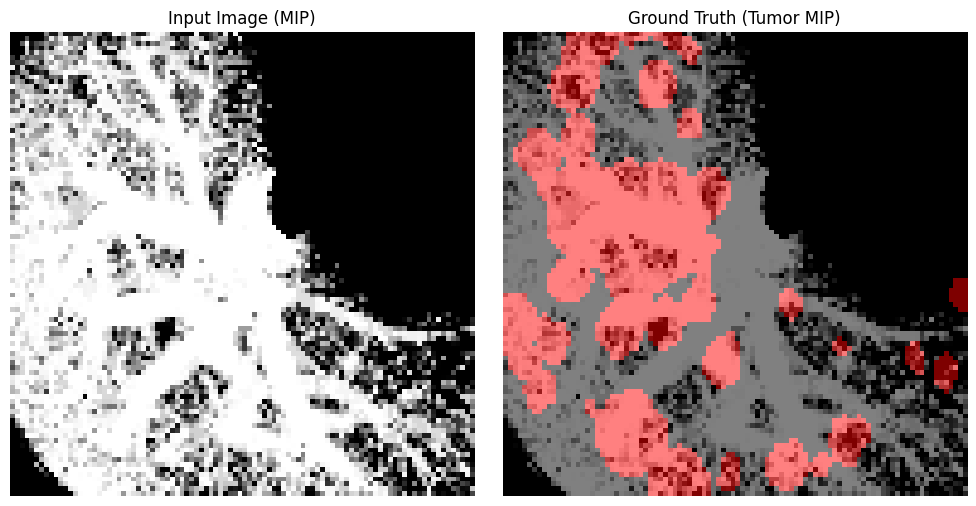

In [14]:
i = 0
for val_data in val_loader:
    i+= 1
    image = val_data["image"]
    label = val_data["label"]

    visualize_from_loader(image, label)
    if i == 10:
      break

## Training

In [10]:
criterion = TverskyLossWSigmoid().to(device)

dice_acc = DiceMetric(include_background=False, reduction='mean_batch', get_not_nans=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=float(config["learning_rate_train"]), weight_decay=float(config["weight_decay"]))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=int(config["max_epochs"]), eta_min = float(config["eta_min"]))

In [11]:
LOGGER.info("[TRAINER] Start TRAIN process...")

(
    val_acc_max,
    best_epoch,
    dices_tumor,
    loss_epochs,
    trains_epoch,
    ious_tumor,
    precisions_tumor,
    recalls_tumor,
    time_tmp
) = trainer_stage2(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_func=criterion,
    acc_func=dice_acc,
    scheduler=scheduler,
    batch_size=config["batch_size"],
    max_epochs = config["max_epochs"],
    start_epoch = config["start_epoch"],
    val_every=config["val_every"],
    path_save_model=config["path_save_model_state"],
    logger=LOGGER,
    save_model=True,
    post_fix="tumor"
)

[TRAINER] Start TRAIN process...
INFO:kltn.utils.logger:[TRAINER] Start TRAIN process...

==============================Training epoch 1==============================
INFO:kltn.utils.logger:
==============================Training epoch 1==============================


Epoch 1/100 1/105 loss: 0.9090 time 6.78s
Epoch 1/100 2/105 loss: 0.9222 time 5.35s
Epoch 1/100 3/105 loss: 0.9245 time 8.64s
Epoch 1/100 4/105 loss: 0.9301 time 1.13s
Epoch 1/100 5/105 loss: 0.9259 time 5.43s
Epoch 1/100 6/105 loss: 0.9222 time 7.59s
Epoch 1/100 7/105 loss: 0.9232 time 1.40s
Epoch 1/100 8/105 loss: 0.9157 time 7.13s
Epoch 1/100 9/105 loss: 0.9161 time 9.65s
Epoch 1/100 10/105 loss: 0.9166 time 8.16s
Epoch 1/100 11/105 loss: 0.9128 time 7.08s
Epoch 1/100 12/105 loss: 0.9142 time 2.75s
Epoch 1/100 13/105 loss: 0.9130 time 8.33s
Epoch 1/100 14/105 loss: 0.9125 time 5.20s
Epoch 1/100 15/105 loss: 0.9118 time 1.37s
Epoch 1/100 16/105 loss: 0.9124 time 3.52s
Epoch 1/100 17/105 loss: 0.9121 time 6.47s
Epoch 1/100 18/105 loss: 0.9127 time 2.53s
Epoch 1/100 19/105 loss: 0.9121 time 2.81s
Epoch 1/100 20/105 loss: 0.9117 time 4.50s
Epoch 1/100 21/105 loss: 0.9118 time 4.54s
Epoch 1/100 22/105 loss: 0.9083 time 4.10s
Epoch 1/100 23/105 loss: 0.9065 time 3.30s
Epoch 1/100 24/105 l

Final training epochs: 1/100 ---[loss: 0.8644] ---[time 481.67s]
INFO:kltn.utils.logger:Final training epochs: 1/100 ---[loss: 0.8644] ---[time 481.67s]

********************Epoch 1 Validation********************
INFO:kltn.utils.logger:
********************Epoch 1 Validation********************


Epoch 1/100 105/105 loss: 0.8644 time 7.01s


Val 1/100 1/26, Dice_Tumor: 0.000452, time 1.96s
INFO:kltn.utils.logger:Val 1/100 1/26, Dice_Tumor: 0.000452, time 1.96s
Val 1/100 2/26, Dice_Tumor: 0.001219, time 1.66s
INFO:kltn.utils.logger:Val 1/100 2/26, Dice_Tumor: 0.001219, time 1.66s
Val 1/100 3/26, Dice_Tumor: 0.000000, time 6.58s
INFO:kltn.utils.logger:Val 1/100 3/26, Dice_Tumor: 0.000000, time 6.58s
Val 1/100 4/26, Dice_Tumor: 0.018508, time 8.15s
INFO:kltn.utils.logger:Val 1/100 4/26, Dice_Tumor: 0.018508, time 8.15s
Val 1/100 5/26, Dice_Tumor: 0.000000, time 1.26s
INFO:kltn.utils.logger:Val 1/100 5/26, Dice_Tumor: 0.000000, time 1.26s
Val 1/100 6/26, Dice_Tumor: 0.000000, time 5.41s
INFO:kltn.utils.logger:Val 1/100 6/26, Dice_Tumor: 0.000000, time 5.41s
Val 1/100 7/26, Dice_Tumor: 0.003274, time 6.03s
INFO:kltn.utils.logger:Val 1/100 7/26, Dice_Tumor: 0.003274, time 6.03s
Val 1/100 8/26, Dice_Tumor: 0.016463, time 4.07s
INFO:kltn.utils.logger:Val 1/100 8/26, Dice_Tumor: 0.016463, time 4.07s
Val 1/100 9/26, Dice_Tumor: 0.00

New best (0.000000 --> 0.009264). At epoch 1
Epoch 2/100 1/105 loss: 0.8236 time 1.28s
Epoch 2/100 2/105 loss: 0.8270 time 4.34s
Epoch 2/100 3/105 loss: 0.8339 time 6.11s
Epoch 2/100 4/105 loss: 0.8392 time 6.99s
Epoch 2/100 5/105 loss: 0.8373 time 1.96s
Epoch 2/100 6/105 loss: 0.8339 time 6.74s
Epoch 2/100 7/105 loss: 0.8326 time 3.26s
Epoch 2/100 8/105 loss: 0.8330 time 2.53s
Epoch 2/100 9/105 loss: 0.8328 time 4.82s
Epoch 2/100 10/105 loss: 0.8300 time 5.86s
Epoch 2/100 11/105 loss: 0.8284 time 5.89s
Epoch 2/100 12/105 loss: 0.8278 time 5.21s
Epoch 2/100 13/105 loss: 0.8274 time 5.66s
Epoch 2/100 14/105 loss: 0.8264 time 1.37s
Epoch 2/100 15/105 loss: 0.8251 time 10.19s
Epoch 2/100 16/105 loss: 0.8240 time 5.39s
Epoch 2/100 17/105 loss: 0.8238 time 6.53s
Epoch 2/100 18/105 loss: 0.8211 time 5.05s
Epoch 2/100 19/105 loss: 0.8206 time 1.56s
Epoch 2/100 20/105 loss: 0.8048 time 7.89s
Epoch 2/100 21/105 loss: 0.8010 time 6.16s
Epoch 2/100 22/105 loss: 0.8013 time 5.83s
Epoch 2/100 23/10

Final training epochs: 2/100 ---[loss: 0.7897] ---[time 482.32s]
INFO:kltn.utils.logger:Final training epochs: 2/100 ---[loss: 0.7897] ---[time 482.32s]

********************Epoch 2 Validation********************
INFO:kltn.utils.logger:
********************Epoch 2 Validation********************


Epoch 2/100 105/105 loss: 0.7897 time 11.82s


Val 2/100 1/26, Dice_Tumor: 0.000000, time 1.81s
INFO:kltn.utils.logger:Val 2/100 1/26, Dice_Tumor: 0.000000, time 1.81s
Val 2/100 2/26, Dice_Tumor: 0.000000, time 1.40s
INFO:kltn.utils.logger:Val 2/100 2/26, Dice_Tumor: 0.000000, time 1.40s
Val 2/100 3/26, Dice_Tumor: 0.000000, time 6.57s
INFO:kltn.utils.logger:Val 2/100 3/26, Dice_Tumor: 0.000000, time 6.57s
Val 2/100 4/26, Dice_Tumor: 0.000000, time 7.37s
INFO:kltn.utils.logger:Val 2/100 4/26, Dice_Tumor: 0.000000, time 7.37s
Val 2/100 5/26, Dice_Tumor: 0.000000, time 1.26s
INFO:kltn.utils.logger:Val 2/100 5/26, Dice_Tumor: 0.000000, time 1.26s
Val 2/100 6/26, Dice_Tumor: 0.000000, time 5.36s
INFO:kltn.utils.logger:Val 2/100 6/26, Dice_Tumor: 0.000000, time 5.36s
Val 2/100 7/26, Dice_Tumor: 0.002500, time 5.71s
INFO:kltn.utils.logger:Val 2/100 7/26, Dice_Tumor: 0.002500, time 5.71s
Val 2/100 8/26, Dice_Tumor: 0.000000, time 4.11s
INFO:kltn.utils.logger:Val 2/100 8/26, Dice_Tumor: 0.000000, time 4.11s
Val 2/100 9/26, Dice_Tumor: 0.00

Epoch 3/100 1/105 loss: 0.7602 time 5.98s
Epoch 3/100 2/105 loss: 0.7653 time 1.40s
Epoch 3/100 3/105 loss: 0.7638 time 5.24s
Epoch 3/100 4/105 loss: 0.7628 time 3.67s
Epoch 3/100 5/105 loss: 0.7650 time 3.18s
Epoch 3/100 6/105 loss: 0.7649 time 1.13s
Epoch 3/100 7/105 loss: 0.7673 time 5.17s
Epoch 3/100 8/105 loss: 0.7668 time 1.83s
Epoch 3/100 9/105 loss: 0.7716 time 9.21s
Epoch 3/100 10/105 loss: 0.7702 time 5.69s
Epoch 3/100 11/105 loss: 0.7695 time 3.08s
Epoch 3/100 12/105 loss: 0.7686 time 7.04s
Epoch 3/100 13/105 loss: 0.7678 time 2.49s
Epoch 3/100 14/105 loss: 0.7673 time 1.58s
Epoch 3/100 15/105 loss: 0.7665 time 4.63s
Epoch 3/100 16/105 loss: 0.7662 time 4.90s
Epoch 3/100 17/105 loss: 0.7684 time 6.75s
Epoch 3/100 18/105 loss: 0.7683 time 6.34s
Epoch 3/100 19/105 loss: 0.7686 time 5.65s
Epoch 3/100 20/105 loss: 0.7680 time 3.78s
Epoch 3/100 21/105 loss: 0.7682 time 6.30s
Epoch 3/100 22/105 loss: 0.7678 time 4.96s
Epoch 3/100 23/105 loss: 0.7673 time 1.42s
Epoch 3/100 24/105 l

Final training epochs: 3/100 ---[loss: 0.7606] ---[time 490.09s]
INFO:kltn.utils.logger:Final training epochs: 3/100 ---[loss: 0.7606] ---[time 490.09s]

********************Epoch 3 Validation********************
INFO:kltn.utils.logger:
********************Epoch 3 Validation********************


Epoch 3/100 105/105 loss: 0.7606 time 3.07s


Val 3/100 1/26, Dice_Tumor: 0.000000, time 1.53s
INFO:kltn.utils.logger:Val 3/100 1/26, Dice_Tumor: 0.000000, time 1.53s
Val 3/100 2/26, Dice_Tumor: 0.000000, time 1.42s
INFO:kltn.utils.logger:Val 3/100 2/26, Dice_Tumor: 0.000000, time 1.42s
Val 3/100 3/26, Dice_Tumor: 0.000000, time 7.18s
INFO:kltn.utils.logger:Val 3/100 3/26, Dice_Tumor: 0.000000, time 7.18s
Val 3/100 4/26, Dice_Tumor: 0.000000, time 7.21s
INFO:kltn.utils.logger:Val 3/100 4/26, Dice_Tumor: 0.000000, time 7.21s
Val 3/100 5/26, Dice_Tumor: 0.000000, time 1.23s
INFO:kltn.utils.logger:Val 3/100 5/26, Dice_Tumor: 0.000000, time 1.23s
Val 3/100 6/26, Dice_Tumor: 0.000000, time 5.54s
INFO:kltn.utils.logger:Val 3/100 6/26, Dice_Tumor: 0.000000, time 5.54s
Val 3/100 7/26, Dice_Tumor: 0.000000, time 5.22s
INFO:kltn.utils.logger:Val 3/100 7/26, Dice_Tumor: 0.000000, time 5.22s
Val 3/100 8/26, Dice_Tumor: 0.000000, time 4.49s
INFO:kltn.utils.logger:Val 3/100 8/26, Dice_Tumor: 0.000000, time 4.49s
Val 3/100 9/26, Dice_Tumor: 0.00

Epoch 4/100 1/105 loss: 0.8049 time 5.17s
Epoch 4/100 2/105 loss: 0.7875 time 2.54s
Epoch 4/100 3/105 loss: 0.7801 time 6.14s
Epoch 4/100 4/105 loss: 0.7752 time 5.51s
Epoch 4/100 5/105 loss: 0.7686 time 3.63s
Epoch 4/100 6/105 loss: 0.7647 time 6.42s
Epoch 4/100 7/105 loss: 0.7660 time 2.27s
Epoch 4/100 8/105 loss: 0.7645 time 5.32s
Epoch 4/100 9/105 loss: 0.7630 time 6.03s
Epoch 4/100 10/105 loss: 0.7630 time 3.46s
Epoch 4/100 11/105 loss: 0.7629 time 1.60s
Epoch 4/100 12/105 loss: 0.7616 time 2.11s
Epoch 4/100 13/105 loss: 0.7598 time 10.22s
Epoch 4/100 14/105 loss: 0.7610 time 6.91s
Epoch 4/100 15/105 loss: 0.7600 time 5.90s
Epoch 4/100 16/105 loss: 0.7605 time 1.89s
Epoch 4/100 17/105 loss: 0.7593 time 6.69s
Epoch 4/100 18/105 loss: 0.7584 time 1.84s
Epoch 4/100 19/105 loss: 0.7582 time 6.08s
Epoch 4/100 20/105 loss: 0.7574 time 4.59s
Epoch 4/100 21/105 loss: 0.7565 time 7.96s
Epoch 4/100 22/105 loss: 0.7558 time 2.23s
Epoch 4/100 23/105 loss: 0.7551 time 1.73s
Epoch 4/100 24/105 

Final training epochs: 4/100 ---[loss: 0.7484] ---[time 485.52s]
INFO:kltn.utils.logger:Final training epochs: 4/100 ---[loss: 0.7484] ---[time 485.52s]

********************Epoch 4 Validation********************
INFO:kltn.utils.logger:
********************Epoch 4 Validation********************


Epoch 4/100 105/105 loss: 0.7484 time 5.84s


Val 4/100 1/26, Dice_Tumor: 0.000000, time 1.54s
INFO:kltn.utils.logger:Val 4/100 1/26, Dice_Tumor: 0.000000, time 1.54s
Val 4/100 2/26, Dice_Tumor: 0.000000, time 1.28s
INFO:kltn.utils.logger:Val 4/100 2/26, Dice_Tumor: 0.000000, time 1.28s
Val 4/100 3/26, Dice_Tumor: 0.000000, time 6.70s
INFO:kltn.utils.logger:Val 4/100 3/26, Dice_Tumor: 0.000000, time 6.70s
Val 4/100 4/26, Dice_Tumor: 0.000000, time 8.06s
INFO:kltn.utils.logger:Val 4/100 4/26, Dice_Tumor: 0.000000, time 8.06s
Val 4/100 5/26, Dice_Tumor: 0.000000, time 1.30s
INFO:kltn.utils.logger:Val 4/100 5/26, Dice_Tumor: 0.000000, time 1.30s
Val 4/100 6/26, Dice_Tumor: 0.000000, time 5.31s
INFO:kltn.utils.logger:Val 4/100 6/26, Dice_Tumor: 0.000000, time 5.31s
Val 4/100 7/26, Dice_Tumor: 0.000000, time 6.54s
INFO:kltn.utils.logger:Val 4/100 7/26, Dice_Tumor: 0.000000, time 6.54s
Val 4/100 8/26, Dice_Tumor: 0.000000, time 4.11s
INFO:kltn.utils.logger:Val 4/100 8/26, Dice_Tumor: 0.000000, time 4.11s
Val 4/100 9/26, Dice_Tumor: 0.00

Epoch 5/100 1/105 loss: 0.7302 time 6.05s
Epoch 5/100 2/105 loss: 0.7321 time 3.65s
Epoch 5/100 3/105 loss: 0.7390 time 6.59s
Epoch 5/100 4/105 loss: 0.7420 time 5.33s
Epoch 5/100 5/105 loss: 0.7454 time 1.39s
Epoch 5/100 6/105 loss: 0.7432 time 1.40s
Epoch 5/100 7/105 loss: 0.7436 time 4.78s
Epoch 5/100 8/105 loss: 0.7432 time 7.13s
Epoch 5/100 9/105 loss: 0.7444 time 6.53s
Epoch 5/100 10/105 loss: 0.7433 time 1.72s
Epoch 5/100 11/105 loss: 0.7420 time 5.09s
Epoch 5/100 12/105 loss: 0.7412 time 1.75s
Epoch 5/100 13/105 loss: 0.7409 time 1.54s
Epoch 5/100 14/105 loss: 0.7402 time 4.39s
Epoch 5/100 15/105 loss: 0.7419 time 2.60s
Epoch 5/100 16/105 loss: 0.7458 time 10.51s
Epoch 5/100 17/105 loss: 0.7451 time 6.48s
Epoch 5/100 18/105 loss: 0.7444 time 3.37s
Epoch 5/100 19/105 loss: 0.7437 time 1.36s
Epoch 5/100 20/105 loss: 0.7461 time 1.41s
Epoch 5/100 21/105 loss: 0.7457 time 2.52s
Epoch 5/100 22/105 loss: 0.7453 time 2.05s
Epoch 5/100 23/105 loss: 0.7448 time 6.50s
Epoch 5/100 24/105 

Final training epochs: 5/100 ---[loss: 0.7417] ---[time 485.44s]
INFO:kltn.utils.logger:Final training epochs: 5/100 ---[loss: 0.7417] ---[time 485.44s]

********************Epoch 5 Validation********************
INFO:kltn.utils.logger:
********************Epoch 5 Validation********************


Epoch 5/100 105/105 loss: 0.7417 time 1.21s


Val 5/100 1/26, Dice_Tumor: 0.000000, time 1.91s
INFO:kltn.utils.logger:Val 5/100 1/26, Dice_Tumor: 0.000000, time 1.91s
Val 5/100 2/26, Dice_Tumor: 0.000000, time 1.44s
INFO:kltn.utils.logger:Val 5/100 2/26, Dice_Tumor: 0.000000, time 1.44s
Val 5/100 3/26, Dice_Tumor: 0.000000, time 6.58s
INFO:kltn.utils.logger:Val 5/100 3/26, Dice_Tumor: 0.000000, time 6.58s
Val 5/100 4/26, Dice_Tumor: 0.000000, time 7.67s
INFO:kltn.utils.logger:Val 5/100 4/26, Dice_Tumor: 0.000000, time 7.67s
Val 5/100 5/26, Dice_Tumor: 0.000000, time 1.24s
INFO:kltn.utils.logger:Val 5/100 5/26, Dice_Tumor: 0.000000, time 1.24s
Val 5/100 6/26, Dice_Tumor: 0.000000, time 5.34s
INFO:kltn.utils.logger:Val 5/100 6/26, Dice_Tumor: 0.000000, time 5.34s
Val 5/100 7/26, Dice_Tumor: 0.000000, time 5.98s
INFO:kltn.utils.logger:Val 5/100 7/26, Dice_Tumor: 0.000000, time 5.98s
Val 5/100 8/26, Dice_Tumor: 0.000000, time 4.12s
INFO:kltn.utils.logger:Val 5/100 8/26, Dice_Tumor: 0.000000, time 4.12s
Val 5/100 9/26, Dice_Tumor: 0.00

Epoch 6/100 1/105 loss: 0.7261 time 5.01s
Epoch 6/100 2/105 loss: 0.7291 time 1.98s
Epoch 6/100 3/105 loss: 0.7296 time 1.56s
Epoch 6/100 4/105 loss: 0.7285 time 6.23s
Epoch 6/100 5/105 loss: 0.7353 time 5.23s
Epoch 6/100 6/105 loss: 0.7362 time 8.21s
Epoch 6/100 7/105 loss: 0.7349 time 3.49s
Epoch 6/100 8/105 loss: 0.7336 time 2.07s
Epoch 6/100 9/105 loss: 0.7329 time 9.61s
Epoch 6/100 10/105 loss: 0.7322 time 1.76s
Epoch 6/100 11/105 loss: 0.7317 time 1.87s
Epoch 6/100 12/105 loss: 0.7312 time 2.05s
Epoch 6/100 13/105 loss: 0.7306 time 1.36s
Epoch 6/100 14/105 loss: 0.7321 time 1.37s
Epoch 6/100 15/105 loss: 0.7316 time 1.30s
Epoch 6/100 16/105 loss: 0.7312 time 5.19s
Epoch 6/100 17/105 loss: 0.7331 time 2.49s
Epoch 6/100 18/105 loss: 0.7334 time 4.85s
Epoch 6/100 19/105 loss: 0.7330 time 6.07s
Epoch 6/100 20/105 loss: 0.7326 time 1.66s
Epoch 6/100 21/105 loss: 0.7323 time 5.62s
Epoch 6/100 22/105 loss: 0.7352 time 9.26s
Epoch 6/100 23/105 loss: 0.7347 time 6.12s
Epoch 6/100 24/105 l

KeyboardInterrupt: 

In [ ]:
import json
path_save_result = f"/content/drive/MyDrive/KLTN/code/result_model_{model.__class__.__name__}_tumor.json"

results = {
    "dice_tumor": [float(x) for x in np.array(dices_tumor, dtype=np.float32)],
    "loss": [float(x) for x in np.array(loss_epochs, dtype= np.float32)],
    "iou_tumor": [float(x) for x in np.array(ious_tumor, dtype=np.float32)],
    "precision_tumor": [float(x) for x in np.array(precisions_tumor, dtype=np.float32)],
    "recall_tumor": [float(x) for x in np.array(recalls_tumor, dtype=np.float32)],
    "best_epoch": best_epoch,
    "time_train": time_tmp
}
with open(path_save_result, "w") as f:
    json.dump(results, f, indent=4)